# Algorytmy macierzowe - zadanie nr 2 - Eliminacja Gaussa i LU Faktoryzacja dla macierzy gęstych

"Proszę wybrać język programowania wedle uznania.
Proszę napisać procedurę [S]=Schur_Complement(A,n,m)
gdzie A to macierz wejściowa, n to rozmiar tej macierzy A,
m to rozmiar podmacierzy (tzw. dopełnienia Schura),
powstałej poprzez wyeliminowanie n-m wierszy i kolumn
z macierzy A, wykorzystując [zatrzymując po n-m krokach]:
 
6. Faktoryzacja Cholesky’ego “wektorową” (slajd 28) 
"

Marcin Hawryluk, Norbert Wolniak <br>grupa: piątek 12:50B <hr>

In [1]:
import numpy as np
from time import time
import matplotlib.pyplot as plt
import pandas as pd
import os

Do implementacji wybraliśmy język Python 3 wraz z biblioteką do obliczeń numerycznych numpy, która pozwala operować na macierzach zaimplementowanych bezpośrednio w języku C.

## Generowanie macierzy

Macierze, których będziemy używać, wygenerowaliśmy za pomocą dostarczonej procedury massmatrix, napisanej w środowisku Octave. Macierze zapisaliśmy w postaci pliku tekstowego, a następnie odczytaliśmy w Pythonie za pomocą poniższej funkcji.

In [2]:
def read_matrix(file_name):
    with open(file_name, 'r') as file:
        for line in file:
            if line.strip() == '':
                continue
            if line[0] == '#':
                if line[2:6] == "rows":
                    _, _, size = line.split()
                    size = int(size)
                    matrix = np.zeros((size, size))
            else:
                row, col, val = line.split(' ')
                matrix[int(row)-1, int(col)-1] = val
            
    return matrix

In [3]:
matrix_small = read_matrix('matrices/riga_2.txt')

* przygotowanie zestawu macierzy do testów:

In [4]:
fem_matrices  = []
riga_matrices = []

for file in os.listdir('matrices'):
    if file.startswith('riga'):
        riga_matrices.append(read_matrix('matrices/' + file))
    if file.startswith('fem'):
        fem_matrices.append(read_matrix('matrices/' + file))

## Faktoryzacja Cholesky'ego

Faktoryzacja Cholesky'ego jest procedurą rozkładu macierzy na czynniki L i L.T (transpozycję L) lub w innym wariancie na macierze L, D, L.T, gdzie macierz L to macierz trójkątna dolna, a D macierz przekątniowa; iloczyn tychże dwóch/trzech macierzy dawać ma wyjściową macierz. Faktoryzacja ta jest możliwa jedynie dla macierzy symetrycznych, dodatnio określonych.

* $A = LDL^T$

In [5]:
def cholesky_LDLT(matrix):
    A = matrix.copy()
    n = A.shape[0]
    
    for k in range(n):
        dkk = A[k, k]
        if abs(dkk) < 1e-8:
            raise ValueError('singular matrix')

        vk = A[k+1:n, k].copy()
        A[k+1:n, k] /= dkk
      
        for j in range(k + 1, n):
            A[j:n, j] -= A[j:n, k] * vk[j-k-1]
            
    D = np.diag(A)*np.eye(n)
    
    return np.tril(A) - D + np.eye(n), D 

* $A = L L^T$

In [6]:
def cholesky_LLT(matrix):
    A = matrix.copy()
    n = A.shape[0]
    
    for k in range(n):
        if abs(A[k, k]) < 1e-8:
            raise ValueError('singular matrix')
            
        vk = A[k+1:n, k]
        A[k, k] **= 0.5
        dkk = A[k, k]
        A[k+1:n, k] /= dkk
        
        for j in range(k+1, n):
            A[j:n, j] -= A[j:n, k]*vk[j-k-1]
        
    return np.tril(A)

* testy poprawności:

In [7]:
matrix = np.array([[4, 4, 6], [4, 13, 15], [6, 15, 43]], dtype=float)
matrix

array([[ 4.,  4.,  6.],
       [ 4., 13., 15.],
       [ 6., 15., 43.]])

In [8]:
L = cholesky_LLT(matrix)

print("---L L.T---")

print("L:\n", L)
print("\nL.T:\n", L.T)
print("\nL*L.T:\n", L @ L.T)

print("\nnumpy L:\n")
print("", np.linalg.cholesky(matrix), "\n")

print("Correct!" if np.allclose(L @ L.T, matrix) else "wrong")

---L L.T---
L:
 [[2. 0. 0.]
 [2. 3. 0.]
 [3. 3. 5.]]

L.T:
 [[2. 2. 3.]
 [0. 3. 3.]
 [0. 0. 5.]]

L*L.T:
 [[ 4.  4.  6.]
 [ 4. 13. 15.]
 [ 6. 15. 43.]]

numpy L:

 [[2. 0. 0.]
 [2. 3. 0.]
 [3. 3. 5.]] 

Correct!


In [9]:
L, D = cholesky_LDLT(matrix)

print("---L D L.T---")

print("L:\n", L)
print("\nD:\n", D)
print("\nL.T:\n", L.T)
print("\nL*D*L.T:\n", L @ D @ L.T)
print()
print("Correct!" if np.allclose(L @ D @ L.T, matrix) else "wrong")

---L D L.T---
L:
 [[1.  0.  0. ]
 [1.  1.  0. ]
 [1.5 1.  1. ]]

D:
 [[ 4.  0.  0.]
 [ 0.  9.  0.]
 [ 0.  0. 25.]]

L.T:
 [[1.  1.  1.5]
 [0.  1.  1. ]
 [0.  0.  1. ]]

L*D*L.T:
 [[ 4.  4.  6.]
 [ 4. 13. 15.]
 [ 6. 15. 43.]]

Correct!


Obydwie wersje znajdują poprawne faktoryzacje zadanej macierzy.

## Dopełnienie Schura

Do znalezienia uzupełnienia Schura o danym rozmiarze m, wykorzystamy procedurę eliminacji w ramach faktoryzacji Cholesky'ego, zatrzymaną po n-m krokach, zwracając jeszcze nie w pełni przetworzoną podmacierz m x m.

* $A = LDL^T$

In [10]:
def schur_LDLT(matrix, m=1):
    A = matrix.copy()
    n = A.shape[0]
    
    for k in range(n-m):
        dkk = A[k, k]
        if abs(dkk) < 1e-8:
            raise ValueError('singular matrix')

        vk = A[k+1:n, k].copy()
        A[k+1:n, k] /= dkk
      
        for j in range(k+1, n):
            A[j:n, j] -= A[j:n, k] * vk[j-k-1]
    
    return A[max(0,n-m):n, max(0,n-m):n]

* $A = L L^T$

In [11]:
def schur_LLT(matrix, m=1):
    A = matrix.copy()
    n = A.shape[0]
    
    for k in range(n-m):
        if abs(A[k, k]) < 1e-8:
            raise ValueError('singular matrix')
            
        vk = A[k+1:n, k]
        A[k, k] **= 0.5
        dkk = A[k, k]
        A[k+1:n, k] /= dkk
        
        for j in range(k+1, n):
            A[j:n, j] -= A[j:n, k]*vk[j-k-1]
        
    return A[max(0,n-m):n, max(0,n-m):n]

In [12]:
print(schur_LDLT(matrix, 2))
print(schur_LLT(matrix, 2))

[[ 9. 15.]
 [ 9. 34.]]
[[ 9. 15.]
 [ 9. 34.]]


### Pomiar czasów

"(...) proszę narysować następujący wykres: <br>
> - oś pozioma: rozmiar macierzy n dla liczby przedziałów nxx=2,3,4,… (tak duże macierze ile się uda policzyć na laptopie), 
> - oś pionowa: czas [s] (Octave tic; Schur Complement(...); toc)  

Proszę narysować 

> a) wykres czasu obliczeń dopełnień Schura o rozmiarze n/2
  <br>b) wykres czasu obliczeń dopełnień Schura o rozmiarze n/4
  <br>c) … takie podziały jakie mają sens do rozmiaru 1"

In [16]:
def compare_times(matrices):
    times = {}
    
    for matrix in matrices:
        n = matrix.shape[0]
        times[n] = {}
        
        start = time()
        schur_LDLT(matrix, n//2)
        times[n]['n/2'] = time() - start
        
        start = time()
        schur_LDLT(matrix, n//4)
        times[n]['n/4'] = time() - start
        
        start = time()
        schur_LDLT(matrix, n//8)
        times[n]['n/8'] = time() - start
        
        start = time()
        schur_LDLT(matrix, 1)
        times[n]['1'] = time() - start
        
    df = pd.DataFrame(times).T.sort_index()
    df.plot(
        figsize=(13, 10),
        xlabel='matrix size (n x n)',
        ylabel='time [s]',
        colormap='Accent',
        linewidth=3,
        markersize=10,
        marker='o'
    )
          
    return df

* dla macierzy IGA riga=0, pxx=2, rxx=0

,n/2,n/4,n/8,1
16,0.000316,0.000403,0.000454,0.000447
25,0.001784,0.001978,0.002175,0.002199
36,0.001467,0.001870,0.001933,0.002005
49,0.006795,0.003280,0.003500,0.003970
64,0.004560,0.005526,0.005953,0.006081
81,0.007389,0.008873,0.009326,0.009530
100,0.010991,0.013904,0.014160,0.014465
121,0.015999,0.019981,0.020936,0.021374
144,0.024041,0.028819,0.030601,0.030712


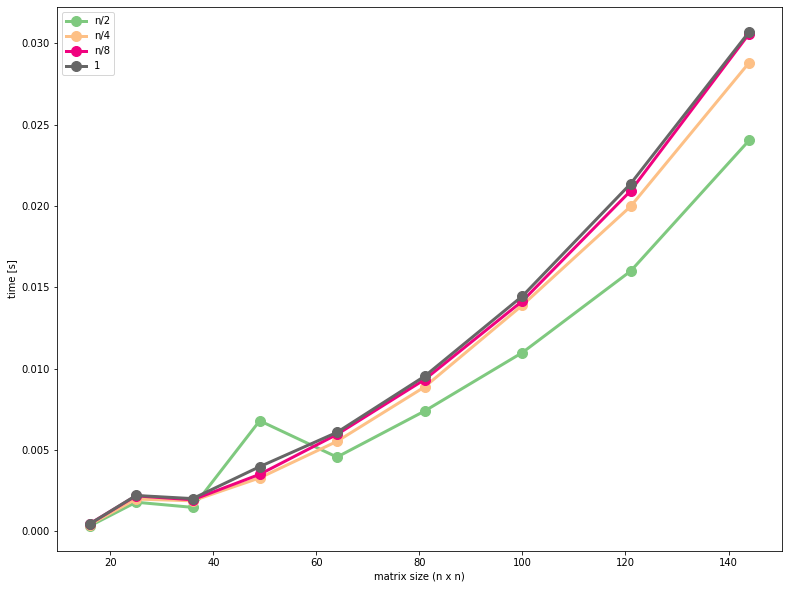

In [17]:
compare_times(riga_matrices)

* dla macierzy FEM riga=1, pxx=2, rxx=0

,n/2,n/4,n/8,1
25,0.000697,0.000859,0.000913,0.000911
49,0.002639,0.003281,0.003445,0.003499
81,0.007069,0.008729,0.009208,0.009349
121,0.015727,0.019557,0.020476,0.020830
169,0.030850,0.038317,0.040261,0.040914
225,0.055663,0.069091,0.072291,0.073496
289,0.101547,0.117280,0.121820,0.124029
361,0.152096,0.186817,0.194843,0.206235
441,0.229148,0.282662,0.294636,0.318449


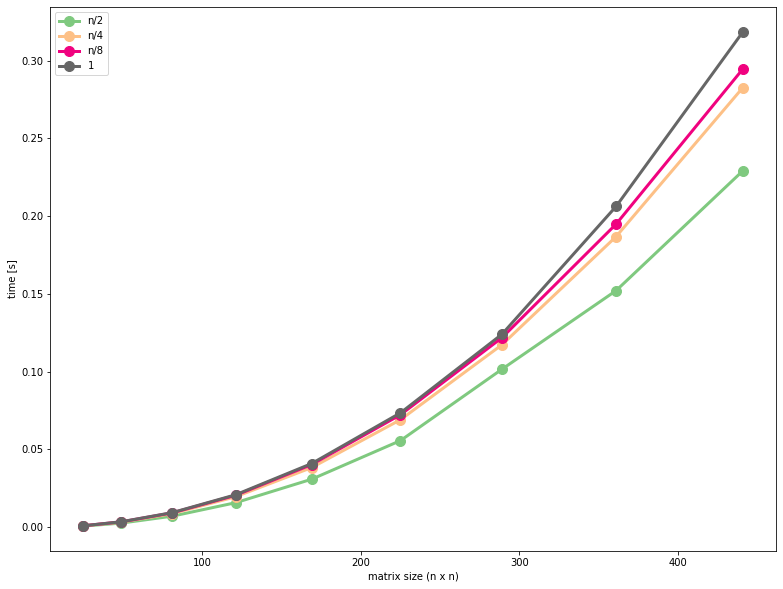

In [18]:
compare_times(fem_matrices)

Otrzymane rezultaty przypominają wykres funkcji wielomianowej (sześciennej), co pokrywa się z oczekiwaniami. Otrzymanie dopełnienia o mniejszym rozmiarze zajmuje więcej czasu, gdyż wymaga większej liczby iteracji w procesie eliminacji. Wyniki czasowe są porównywalne dla dwóch typów macierzy, nie zaobserwowaliśmy wyraźnej przewagi którejkolwiek z nich.

## Koszt obliczeniowy i pamięciowy

"3. Jaki jest koszt obliczeniowy i pamięciowy (flopsy i memopsy) zaimplementowanego
algorytmu?"

Poniższe obliczenia dotyczą faktoryzacji Cholesky'ego w wersji LDL.T:

Koszt obliczeniowy (flops): <br>
$$ \sum \limits _{k=0} ^{n-1} [(n-k-1) + \sum \limits _{j=k+1} ^{n} (n-j)*2] $$ <br>
$$ \sum \limits _{k=0} ^{n-1} [(n-k-1) + (k-n)*(1+k-n)]$$ <br>
$$ \frac{1}{3}n^3 +\frac{1}{2}n^2 -\frac{5}{6}n $$ <br>
Koszt pamięciowy (memops): <br>
$$ \sum \limits _{k=0} ^{n-1} [3 + 4*(n-k-1) + \sum \limits _{j=k+1} ^{n} 1 + 2*(n-j)] $$ <br>
$$ \sum \limits _{k=0} ^{n-1} [3 + 4*(n-k-1) + (k - n)^2] $$ <br>
$$ \frac{1}{3}n^3 + \frac{15}{6}n^2 + \frac{7}{6}n $$ <br>

## Wnioski

* Za pomocą zarówno eliminacji Gaussa, jak i faktoryzacji Cholesky'ego, jesteśmy w stanie otrzymać dopełnienie Schura, które znajduje zastosowanie w wielu działach matematyki, m.in. w statystyce, rachunku prawdopodobieństwa, algebrze (do rozwiązywania układu równań liniowych).
* Algorytm faktoryzacji LDL^T ma porównywalne koszty obliczeniowe i pamięciowe rzędu n^3.

M. Hawryluk, N. Wolniak. 2021